<h1><center>AI Launch Lab - Student Club Project</center></h1>
<center>Team 1: Zaccaria Broomhall Bedont, Alexander Derderian, Alexander Segal, Noah Vezina</center>
&nbsp;

***

Note: our files can also be found on our __[github](https://github.com/noahvezina26/student-clubs-ml)__ and the demo website __[here](https://blank-app-jh6mkh1vru.streamlit.app/#7700d050)__ 

## Step 1: Defining our Problem and Scope

### Problem definition:
A classification model that provides school club recommendations to students
based on past student data aimed to help students better integrate in the school community and improve themselves.

### Target audience:
* Students can use this to find what they are likely to enjoy

* Schools can use this to recommend activities to students

### Scope and constraints:
* We will only be analyzing the ten data fields found in our dataset with a focus on making a classification model

* Club recommendations will be very general, given the data (e.g. "Art Club" or "Sports Team")

* Later, we could implement:

    * Language models for more natural/human results

    * Bias study by hiding certain data fields and see how it affects results
    
    * School specific datasets compatibility
    
### Success criteria:

We can use certain metrics such as subset accuracy, precision, recall, F1 score, and hamming loss to judge the effectiveness of our model. We can also use data visualizations like confusion matrices to get insight into our model's overall performance.

## Step 2: Data Collection and Preparation

### Data source:

We are going to use a __[student extracurricular dataset](https://www.kaggle.com/datasets/kamakshilahoti/student-extracurriculars-info)__ from Kaggle.
We'll begin by exploring, and cleaning the data.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

url = "https://raw.githubusercontent.com/noahvezina26/student-extracurriculars/refs/heads/main/student_data.csv"

df = pd.read_csv(url)

df.head()

,StudentID,Name,AcademicInterest,ExtracurricularActivities,Skills,Location,YearOfStudy,Major,GPA,Languages,ClubMemberships,ResearchInterests
0,1,Student 1,Psychology,Debate Club,Problem Solving,New York,Freshman,Psychology,3.27,"Chinese, Japanese, Spanish, German, French","Music Club, Art Club, Sports Team, Debate Club...",Biomedical Engineering
1,2,Student 2,Psychology,Debate Club,"Leadership, Problem Solving, Public Speaking, ...",Boston,Graduate,Physics,3.17,"French, English, Chinese, Spanish, Japanese","Art Club, Music Club, Sports Team, Coding Club",Urban Planning
2,3,Student 3,History,Volunteer Group,"Data Analysis, Leadership, Public Speaking, Ar...",Chicago,Junior,Biology,2.09,"Spanish, Japanese, German, French","Music Club, Art Club, Debate Club, Volunteer G...",Nanotechnology
3,4,Student 4,Computer Science,Volunteer Group,"Public Speaking, Data Analysis, Problem Solving",Chicago,Graduate,Biology,2.56,"Japanese, Chinese, Spanish, French","Sports Team, Volunteer Group",Space Exploration
4,5,Student 5,Computer Science,Sports Team,Data Analysis,Chicago,Graduate,Computer Science,2.01,English,"Sports Team, Volunteer Group, Music Club",Climate Change


Taking a look at the dataframe, we can see that the first two columns are of no real value, so we can remove them. Moreover, we can reorder the columns to make the data a bit more readable. Notice that columns like "Skills", "Languages", "ResearchInterests" or "ClubMemberships" contains multiple values and therefore count each value combination as a unique value. This is very hard to analyze and makes it difficult to comb through the data. Later, we will use multihot encoding to simplify these values, after some data exploration. 

There's also some overlap between extracurricular activities and club memberships features. As of yet, we have been using the terms somewhat interchangeably; however, extracurriculars are typically considered activities done out of school, whereas clubs are activities done in-school. Because of the similarity between the two categories and the overlap between them, we are going to remove the feature with less granularity, "ExtracurricularActivities".

In [15]:
df.drop("StudentID", axis=1, inplace=True, errors="ignore")
df.drop("Name", axis=1, inplace=True, errors="ignore")
df.drop("ExtracurricularActivites", axis=1, inplace=True, errors="ignore")

column_order = [
    "Location",
    "YearOfStudy",
    "Major",
    "GPA",
    "AcademicInterest",
    "ResearchInterests",
    "Skills",
    "Languages",
    "ClubMemberships",
]

df = df[column_order]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           1000 non-null   object 
 1   YearOfStudy        1000 non-null   object 
 2   Major              1000 non-null   object 
 3   GPA                1000 non-null   float64
 4   AcademicInterest   1000 non-null   object 
 5   ResearchInterests  1000 non-null   object 
 6   Skills             1000 non-null   object 
 7   Languages          1000 non-null   object 
 8   ClubMemberships    1000 non-null   object 
dtypes: float64(1), object(8)
memory usage: 70.4+ KB


### Data attributes:

That leaves us with 1000 datapoints and 10 data attributes including:
* Location: city where student is based
* Year Of Study: year of study (e.g. Freshman, Junior, Senior, Graduate)
* Major: student's major
* GPA: grade point average of student
* Academic Interest: field of study of the student
* Research Interests: specific interests of the students
* Skills: skills possessed by the student
* Languages: languages spoken by the student
* Club Memberships: student's memberships in clubs (within the school community)

Among these, GPA is the only numerical attribute whereas the rest are categorical. Unfortunately, our dataset also provides no specifics on the differences between academic and research interests.

### Data cleaning:

Let's check for duplicated rows and missing data:

In [16]:
print("Missing values per column:")
print(df.isnull().values.sum())

print()

print("Amount of duplicated rows:")
print(df.duplicated().sum())

Missing values per column:
0

Amount of duplicated rows:
0


Lastly, let's check how many unique values there are in each column. This ensures that everything is spelled and capitalized uniformly.

In [17]:
categorical_features = [feature for feature in df.columns if feature != "GPA"]

for feature in categorical_features:
    unique_values = df[feature].str.split(", ").explode().unique()
    print(f"Unique values of {feature} ({len(unique_values)}):\n {unique_values}\n")

print(f"Range of GPA: {df["GPA"].min()} - {df["GPA"].max()}")

Unique values of Location (6):
 ['New York' 'Boston' 'Chicago' 'Houston' 'Los Angeles' 'San Francisco']

Unique values of YearOfStudy (5):
 ['Freshman' 'Graduate' 'Junior' 'Senior' 'Sophomore']

Unique values of Major (6):
 ['Psychology' 'Physics' 'Biology' 'Computer Science' 'History'
 'Mathematics']

Unique values of AcademicInterest (6):
 ['Psychology' 'History' 'Computer Science' 'Biology' 'Mathematics'
 'Physics']

Unique values of ResearchInterests (25):
 ['Biomedical Engineering' 'Urban Planning' 'Nanotechnology'
 'Space Exploration' 'Climate Change' 'Machine Learning' 'Cybersecurity'
 'Environmental Sustainability' 'Bioinformatics' 'Social Sciences'
 'Quantum Computing' 'Cognitive Psychology' 'Robotics'
 'Blockchain Technology' 'Astrophysics' 'Educational Technology'
 'Data Science' 'Artificial Intelligence' 'Renewable Energy'
 'Human-Computer Interaction' 'Behavioral Economics'
 'Healthcare Management' 'Political Science' 'Natural Language Processing'
 'Sustainable Agriculture

Fortunately, everthing is spelled correctly and all the values names are uniform; no duplicates are present.

## Step 3: Exploratory Data Analysis

### Importance of Statistics:
Statistics are an essential tool for the formation of a model, as they are frequently used in
 * Data analysis to understand the relation between all the columns
 * Anomaly detection to catch all the missing or non-uniform data to avoid errors while training your model
 * Preprocessing data to eliminate any anomalies, removing them such that your dataset is consistent
 * Model evaluation to understand optimal accuracy rates and interpreting the outputs from the trained model, avoiding the deployment of a faulty model
    
In our case some key statistical measures include: NEED TO REVISE
1. General Measures such as
    * Mean (average)
    * Median (Middle no.)
2. Measures used to evaluate the effectiveness of our classification model such as
    * Accuracy using a Cross entropy loss functions
    * Confusion Matrix 
3. Graph types are present such as
    * bar graph

### Numerical Graph:

The only numerical feature in our dataset is GPA. We can look at it's distribution with a histogram.

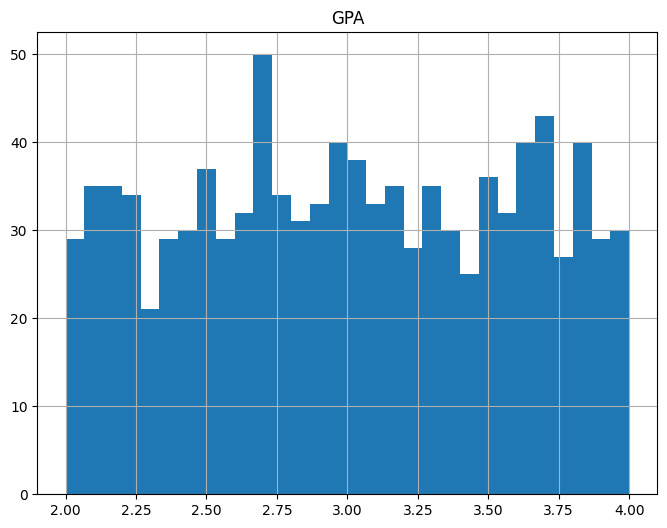

In [18]:
numerical_features = ["GPA"]
df[numerical_features].hist(bins=30, figsize=(8, 6))
plt.show()

### Categorical Graphs:

Now, let's look at the graphs for our categorical and multi-categorical values.

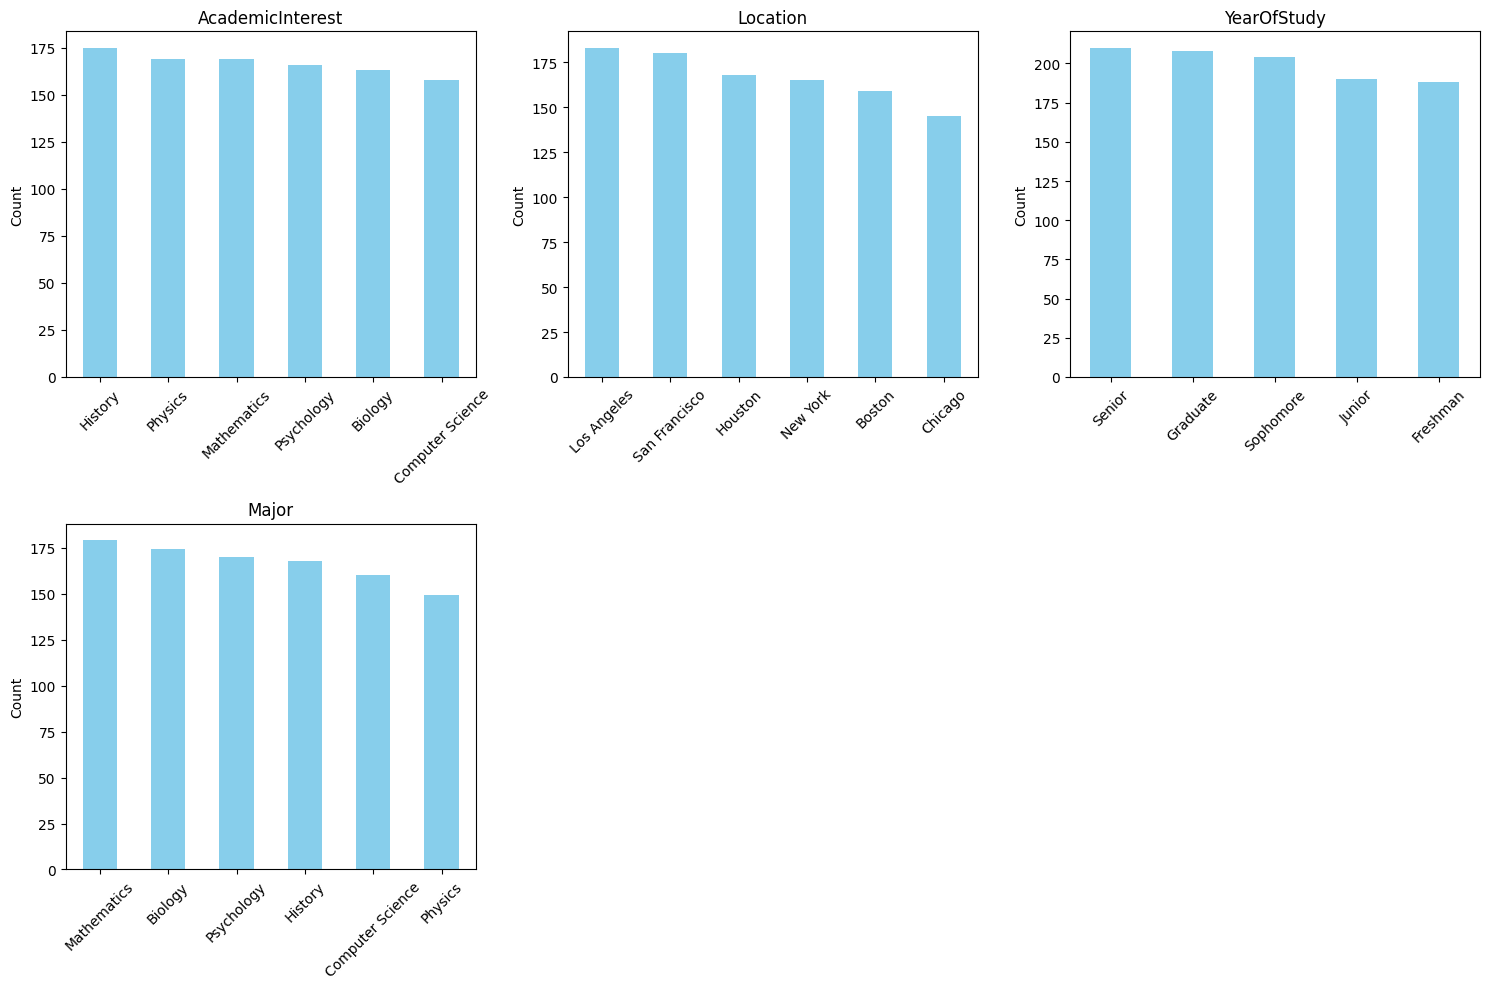

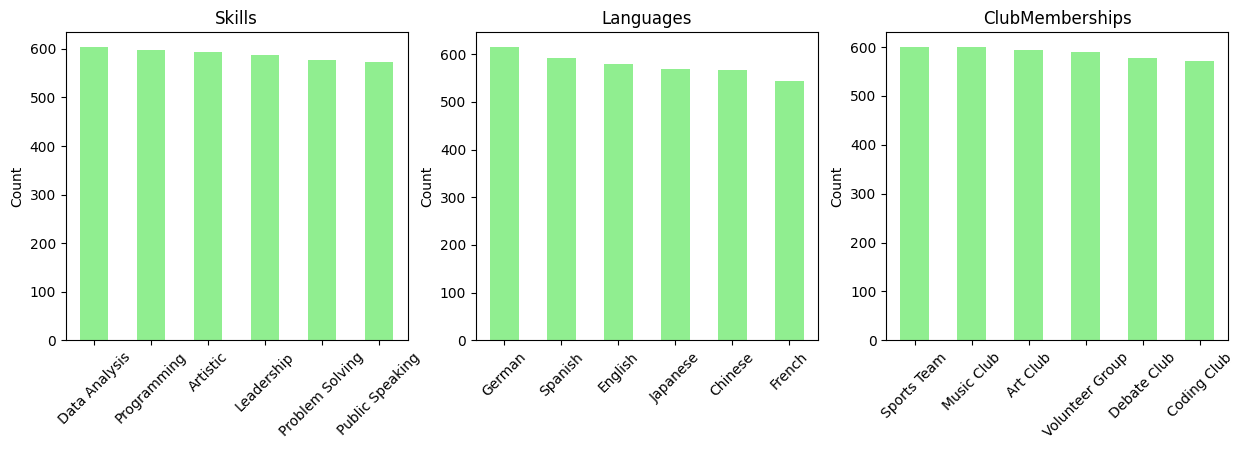

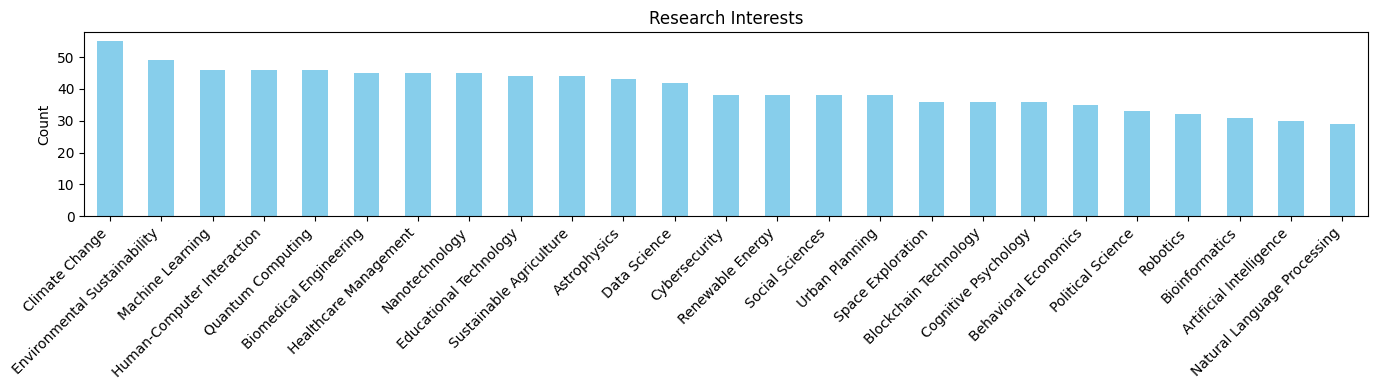

In [19]:
categorical_features = ["AcademicInterest", "Location", "YearOfStudy", "Major"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    df[feature].value_counts().plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

multi_categorical_features = ["Skills", "Languages", "ClubMemberships"]
fig, axes = plt.subplots(1, len(multi_categorical_features), figsize=(15, 4))
for i, feature in enumerate(multi_categorical_features):
    exploded_feature = df[feature].str.split(", ").explode()
    exploded_feature.value_counts().plot(kind='bar', color='lightgreen', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

categorical_features.append("ResearchInterests")

plt.figure(figsize=(14, 4))
research_interests = df["ResearchInterests"].str.split(", ").explode()
research_interests.value_counts().plot(kind='bar', color='skyblue')
plt.title("Research Interests")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these graphs, we can see that the data is fairly uniform.  Interestingly enough, only a little less than 600 of the students have Enlgish as one of their spoken languages. Seen as this dataset is looking at American students, English should be spoken by nearly all the students. We will assume that this was an error made by the original creators of the dataset, and as such, we can add it to every student. Moreover, when looking at ResearchInterests, Major, and AcademicInterests, we can see that our dataset is mostly looking at STEM students. Lastly, to better understand our data, it might be beneficial to categorize our GPA into low, medium, high and compare it to our other features.

In the code block below, we add English to each student, if they don't already have it. While it may seem counterintuitive, it ensures we don't remove the sole language of students who *only* speak English.

In [20]:
from pandas.api.types import infer_dtype

if infer_dtype(df["Languages"]) == "string":
    df["Languages"] = df["Languages"].str.split(", ")
df["Languages"] = df["Languages"].apply(lambda x: x + ["English"] if "English" not in x else x)

### Clubs Memberships vs Other Features:

Next, let's categorize GPA into low, medium, and high as to get more insights into our data. We'll also plot our clubs against other features like year of study, major, location, etc.

In [21]:
def categorize_gpa(gpa):
    if gpa <= 2.5:
        return "low"
    elif gpa <= 3:
        return "medium"
    elif gpa <= 3.5:
        return "high"
    else:
        return "very high"
    
df["CategoricalGPA"] = df["GPA"].apply(categorize_gpa)

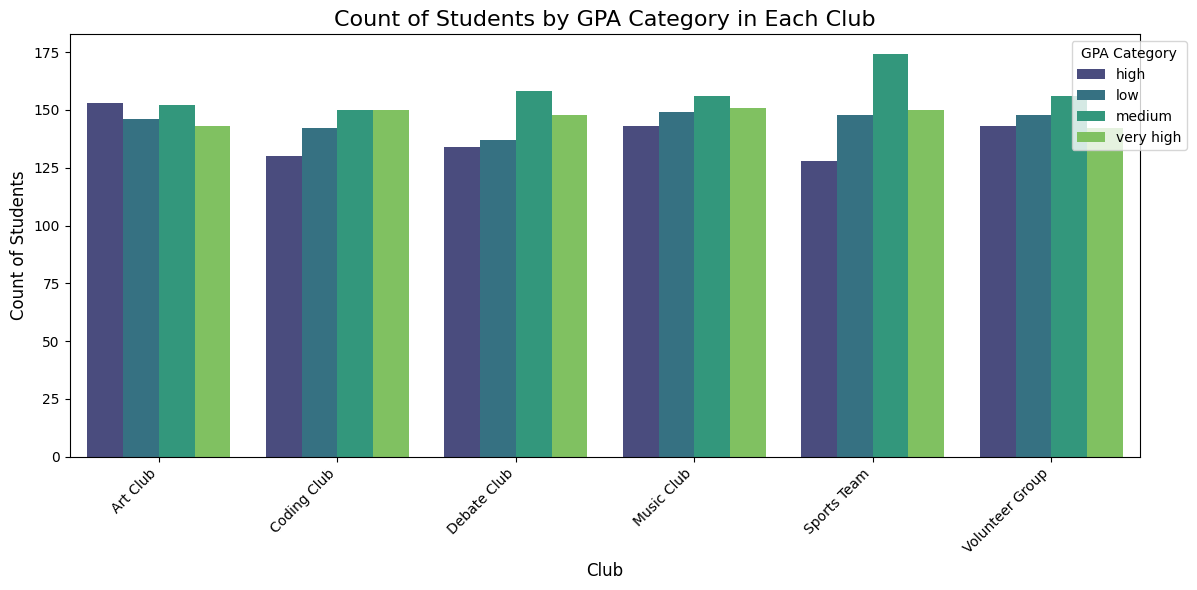

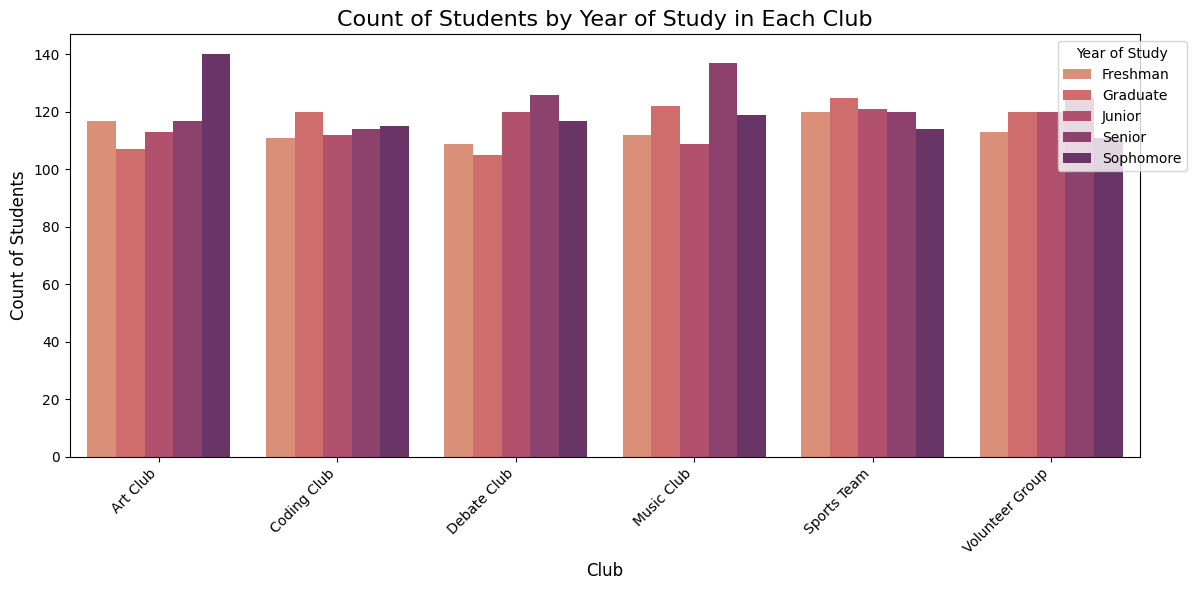

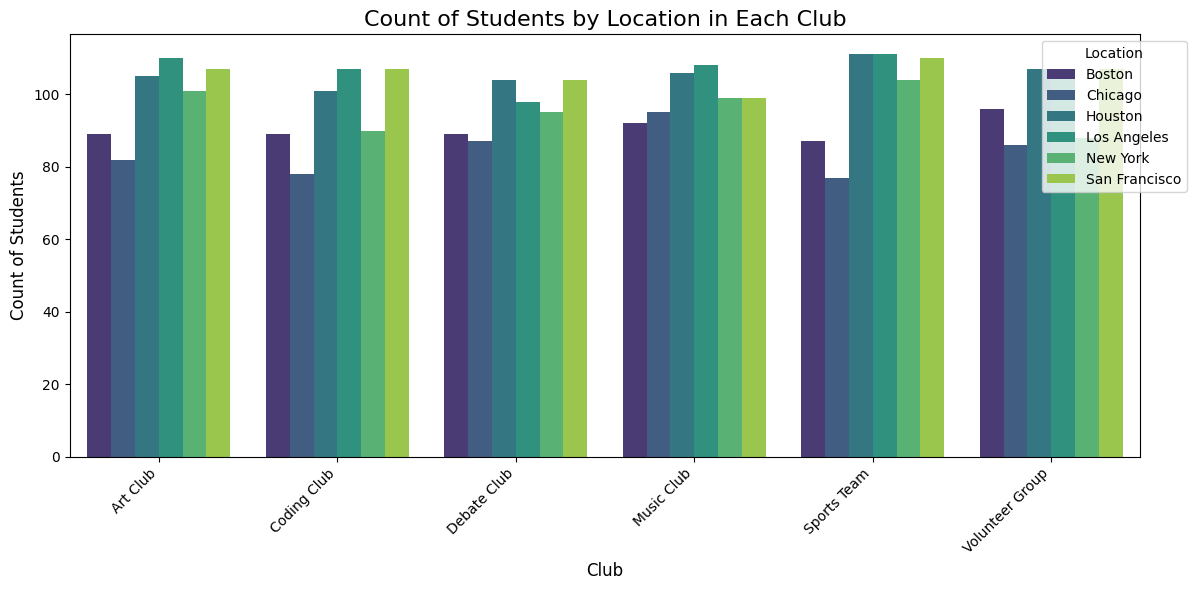

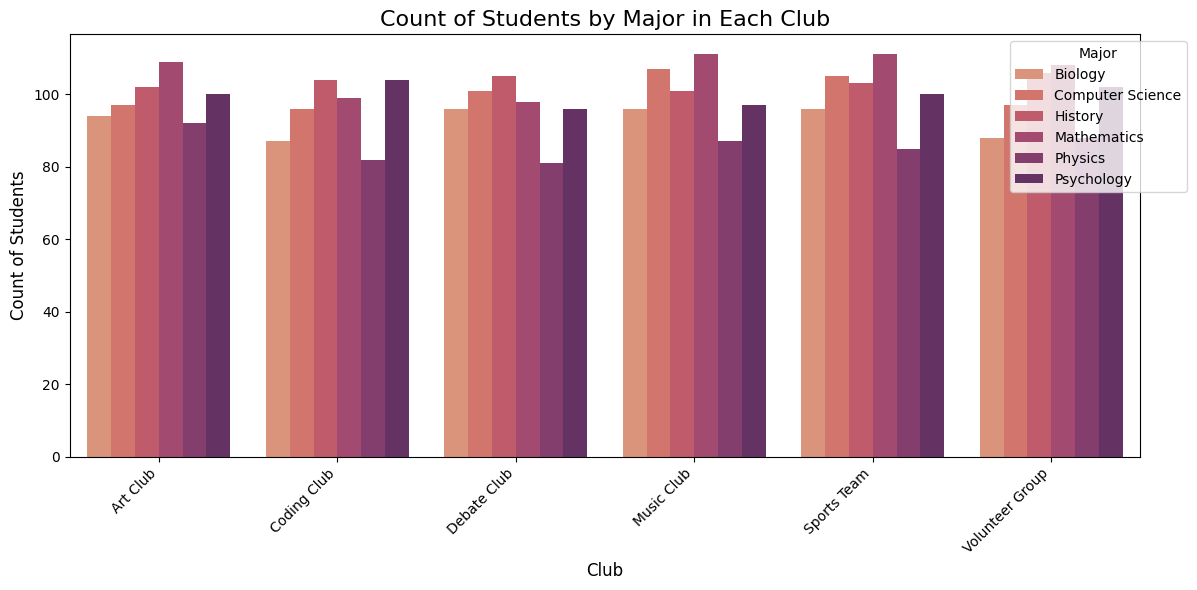

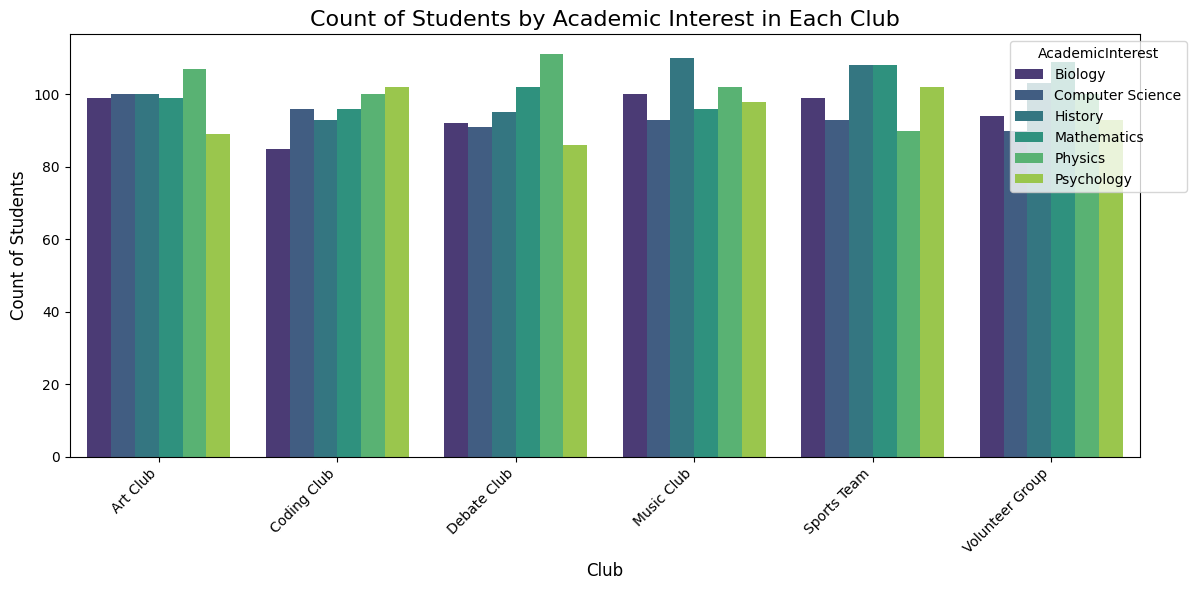

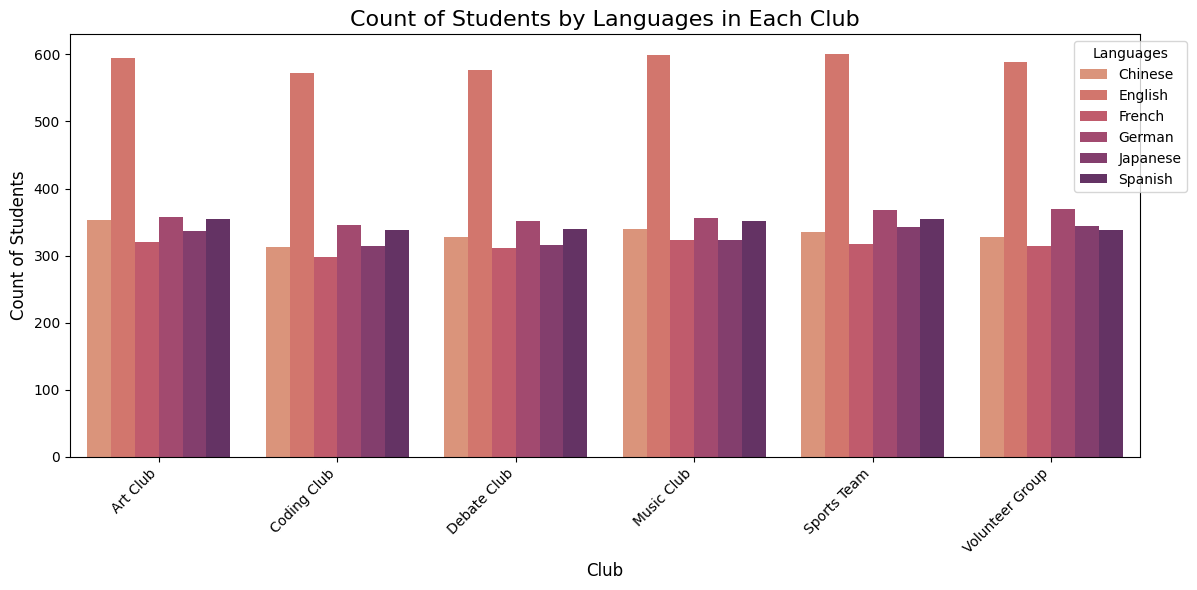

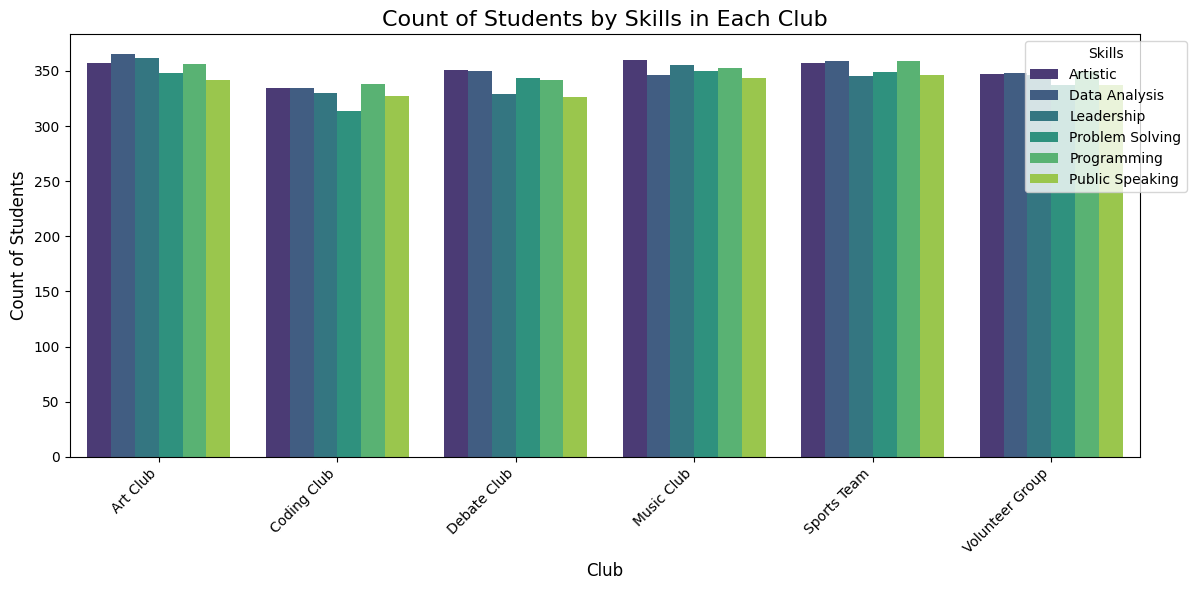

In [22]:
from pandas.api.types import CategoricalDtype, infer_dtype

def plot_club_counts(data, group_by, hue, palette, title, legend_title):

    counts = data.groupby(group_by).size().reset_index(name='Count')
    
    plt.figure(figsize=(12, 6))
    
    if hue in counts.columns:
        sns.barplot(data=counts, x=group_by[1], y='Count', hue=hue, palette=palette)
    else:
        sns.barplot(data=counts, x=group_by[1], y='Count', palette=palette) 
    

    if hue in counts:
        plt.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    plt.title(title, fontsize=16)
    plt.xlabel('Club', fontsize=12)
    plt.ylabel('Count of Students', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


if infer_dtype(df["ClubMemberships"]) == "string":
    df['ClubMemberships'] = df['ClubMemberships'].str.split(', ')
df_exploded = df.explode('ClubMemberships')


plot_club_counts(
    data=df_exploded,
    group_by=['CategoricalGPA', 'ClubMemberships'],
    hue='CategoricalGPA',
    palette="viridis",
    title='Count of Students by GPA Category in Each Club',
    legend_title='GPA Category'
)

plot_club_counts(
    data=df_exploded,
    group_by=['YearOfStudy', 'ClubMemberships'],
    hue='YearOfStudy',
    palette="flare",
    title='Count of Students by Year of Study in Each Club',
    legend_title='Year of Study'
)

plot_club_counts(
    data=df_exploded,
    group_by=['Location', 'ClubMemberships'],
    hue='Location',
    palette="viridis",
    title='Count of Students by Location in Each Club',
    legend_title='Location'
)

plot_club_counts(
    data=df_exploded,
    group_by=['Major', 'ClubMemberships'],
    hue='Major',
    palette="flare",
    title='Count of Students by Major in Each Club',
    legend_title='Major'
)

plot_club_counts(
    data=df_exploded,
    group_by=['AcademicInterest', 'ClubMemberships'],
    hue='AcademicInterest',
    palette="viridis",
    title='Count of Students by Academic Interest in Each Club',
    legend_title='AcademicInterest'
)


if infer_dtype(df["Languages"]) == "string":
    df_exploded['Languages'] = df_exploded['Languages'].str.split(', ')
df_exploded_languages = df_exploded.explode('Languages')

plot_club_counts(
    data=df_exploded_languages,
    group_by=['Languages', 'ClubMemberships'],
    hue='Languages',
    palette="flare",
    title='Count of Students by Languages in Each Club',
    legend_title='Languages'
)


if infer_dtype(df["Skills"]) == "string":
    df_exploded['Skills'] = df_exploded['Skills'].str.split(', ')
df_exploded_skills = df_exploded.explode('Skills')

plot_club_counts(
    data=df_exploded_skills,
    group_by=['Skills', 'ClubMemberships'],
    hue='Skills',
    palette="viridis",
    title='Count of Students by Skills in Each Club',
    legend_title='Skills'
)


Once again, our data is fairly uniform. Though, we do see a little correlation between GPAs and certain clubs. For example, those with very high GPAs are a little less likely to be in a sports team. Conversely, they are more likely to be in an art club. More notably, there seems to be a stronger correlation in between AcademicInterests and ClubMemberships. For example, people in debate are more likely to be interested in physics, while those in the music club are more likely to be interested in history. As a whole, however, very few correlations can be established.

## Step 4: Model Selection and Design

### Encoding Categorical Features:

Before selecting a model we should encode our categorical values. For our multi value categorical features, we use multi-hot encoding to represent the presence of certain values. For example, given an arbitary student, the Languages category would be split into six columns containing ones and zeros that indicates whether  they speak each language, specifically the ones assigned to the positions containing ones. As for our other categorical feautes, we can use one-hot encoding, which encodes features in a similar fashion. We can also drop the features we wil not use anymore.

In [23]:
import sklearn.preprocessing

mlb = sklearn.preprocessing.MultiLabelBinarizer()
ohe = sklearn.preprocessing.OneHotEncoder(dtype=int, sparse_output=False)

for feature in multi_categorical_features:
    if infer_dtype(df[feature]) == "string":
        df[feature] = df[feature].str.split(", ")
    encoded = mlb.fit_transform(df[feature])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(feature, axis=1, inplace=True)
    if feature == "ClubMemberships":
        target = encoded_df

for feature in categorical_features:
    encoded = ohe.fit_transform(df[[feature]])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([feature]))
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(feature, axis=1, inplace=True)

df.drop("CategoricalGPA", axis=1, inplace=True)

### Model Research:
When making an ML model, it's important to pick the right learning algorithm for the best success of the AI. For our project, we are going to use a random forest classifier from scikit-learn. When looking at an ML model, it's important to ask ourselves the following questions. Is it appropriate for our type of problem? Is it appropriate for our dataset?

### Model Architecture:

How do random forest classifiers work? Random forests are actually the combination of many models working together to make predictions. These smaller models are different decision trees (hence the name forest). Looking at smaller subsets of the data (which may contain different features), each tree arrives to a conclusion. Then, the forest takes the most "popular" prediction made by the trees. By taking these sub-samples and comparing them, it improves the overall accuracy of the model.

This classifier can take in many parameters, making it hyper-customizable.

However, these classifiers cannot, by themselves, handle a multi-label classification problem such as ours. Therefore we will "wrap" it inside a MultiOutputClassifier from scikit-learn. This wrapper will manage the random forest classiifier for each distinct label and merge the results.

### Optimizations:

To optimize our model, we can modify certain parameters, including:

* The number of estimators or trees

* The maximum depth of a tree

* The minium sample split size

* Custom feature weights

### Rationale

Our choice of model can be explained by the following reasons:

* It fits our problem as we have a multi-label classification problem

* We have an appropriate dataset that is relatively small and fairly uniform

* The model is less ethically objectionable as it uses comparatively little resources and more importantly is not a black box algorithm

## Step 5: Model Training and Evaluation

### Training Process:

The training process is relatively simple. First, we set the features we're going to use to make our predictions as well as our target feature itself, the students' club memberships. Next, we can split those into training, validation and testing sets. Lastly, we fit our model to the data and make predictions based on our testing set.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

X = df[[feature for feature in df.columns if feature not in target.columns]]

y = target

model = MultiOutputClassifier(RandomForestClassifier())

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

### Validation:

Some important metrics used to evaluate a multi-label classification problem include:

* <ins>Subset accuracy:</ins> ratio of how many predicted labels match the real values

* <ins>Precision:</ins> ratio of correct predicted positive values

* <ins>Recall:</ins> ratio of correct actual positive values

* <ins>F1 score:</ins> harmonic mean of precision and recall

* <ins>Hamming loss:</ins> ratio of incorrect predictions

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss

subset_accuracy = accuracy_score(y_val, y_pred)
print(f"Subset Accuracy (Exact Match Ratio): {subset_accuracy:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(np.array(y_val), y_pred, average='macro')
print(f"Macro-average Precision: {precision:.4f}")
print(f"Macro-average Recall: {recall:.4f}")
print(f"Macro-average F1 Score: {f1:.4f}")

hamming = hamming_loss(y_val, y_pred)
print(f"\nHamming Loss: {hamming:.4f}")

labels = ["Art Club", "Coding Club", "Debate Club", "Music Club", "Sports Team", "Volunteer Group"]
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
for i, label in enumerate(mlb.classes_):
    print(f"\nLabel: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")

Subset Accuracy (Exact Match Ratio): 0.0500
Macro-average Precision: 0.5699
Macro-average Recall: 0.7702
Macro-average F1 Score: 0.6522

Hamming Loss: 0.4692

Label: Art Club
  Precision: 0.5260
  Recall: 0.8835
  F1 Score: 0.6594

Label: Coding Club
  Precision: 0.5822
  Recall: 0.7391
  F1 Score: 0.6513

Label: Debate Club
  Precision: 0.6204
  Recall: 0.6800
  F1 Score: 0.6489

Label: Music Club
  Precision: 0.5714
  Recall: 0.8496
  F1 Score: 0.6833

Label: Sports Team
  Precision: 0.5714
  Recall: 0.7797
  F1 Score: 0.6595

Label: Volunteer Group
  Precision: 0.5479
  Recall: 0.6897
  F1 Score: 0.6107



### Iteration:

At a glance, our model performed rather poorly. One of the key metrics we must consider is hamming loss, the ratio of incorrect results. One issue might be the sheer amount of features and labels. As such, we should not be overly worried about not getting that many exact matches due to the nature of our problem. We can do a couple things to mitigate this issues including: fine-tuning hyperparameters as well as some visualizations of our results.

Now that we've seen how the model performs under default parameters, we're going to use a randomized search hyperparameter tuner. This gives us the parameters which maximize our model's performance. As such, we might get better results.

In [26]:
from sklearn.model_selection import RandomizedSearchCV

model = MultiOutputClassifier(RandomForestClassifier())

param_dist = {
    'estimator__n_estimators': np.arange(100, 500, 50),
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1, verbose=2, error_score="raise")
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'estimator__n_estimators': np.int64(200), 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


Now that we've tuned our model, we can rerun our metrics ad see if there was any improvement!

In [27]:
subset_accuracy = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy (Exact Match Ratio): {subset_accuracy:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(np.array(y_test), y_pred, average='macro')
print(f"Macro-average Precision: {precision:.4f}")
print(f"Macro-average Recall: {recall:.4f}")
print(f"Macro-average F1 Score: {f1:.4f}")

hamming = hamming_loss(y_test, y_pred)
print(f"\nHamming Loss: {hamming:.4f}")

labels = ["Art Club", "Music Club", "Debate Club", "Sports Team", "Volunteer Group", "Coding Club"]
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, label in enumerate(mlb.classes_):
    print(f"\nLabel: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")

Subset Accuracy (Exact Match Ratio): 0.1150
Macro-average Precision: 0.5993
Macro-average Recall: 0.9048
Macro-average F1 Score: 0.7208

Hamming Loss: 0.4175

Label: Art Club
  Precision: 0.5989
  Recall: 0.9412
  F1 Score: 0.7320

Label: Coding Club
  Precision: 0.5795
  Recall: 0.8644
  F1 Score: 0.6939

Label: Debate Club
  Precision: 0.5740
  Recall: 0.8739
  F1 Score: 0.6929

Label: Music Club
  Precision: 0.6053
  Recall: 0.9583
  F1 Score: 0.7419

Label: Sports Team
  Precision: 0.6324
  Recall: 0.9360
  F1 Score: 0.7548

Label: Volunteer Group
  Precision: 0.6057
  Recall: 0.8548
  F1 Score: 0.7090


Overall, hyperparameter tuning did help slightly in improving our results. The final thing we are going to do is visualize some confusion matrices.

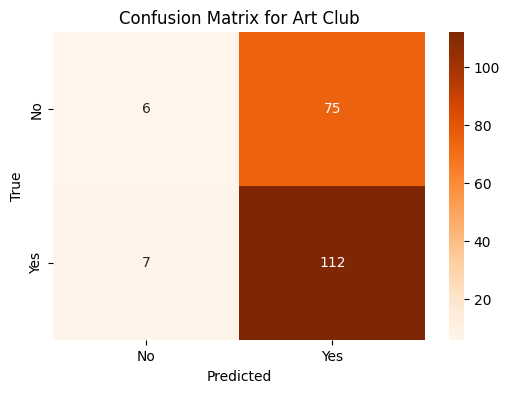

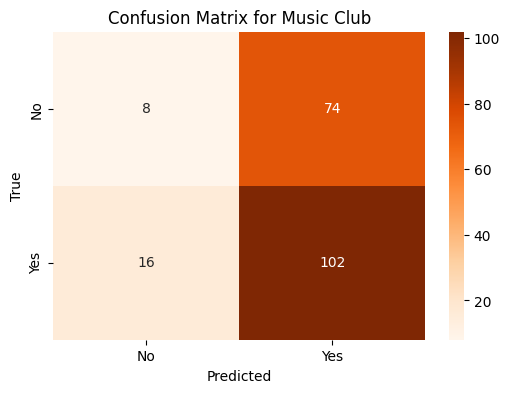

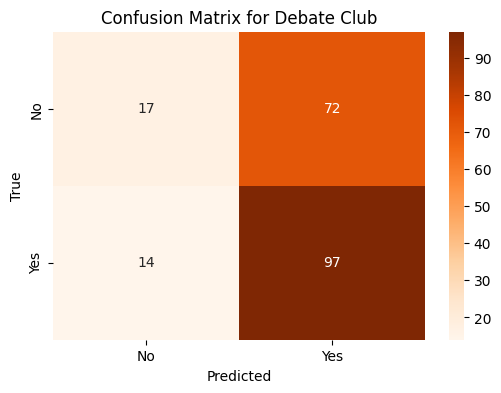

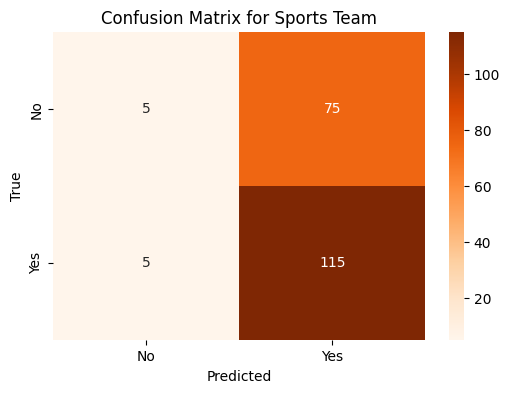

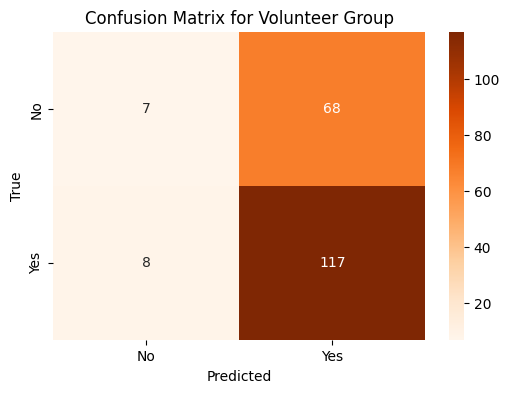

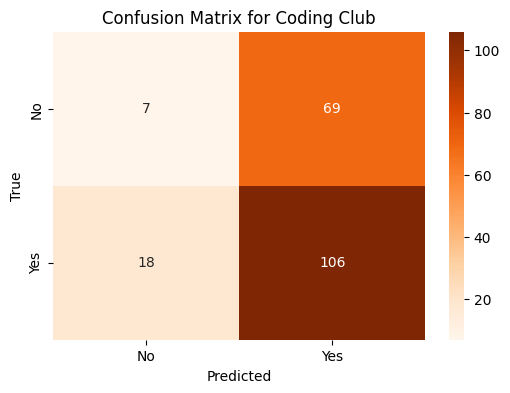

In [28]:
from sklearn.metrics import  multilabel_confusion_matrix

matrices = multilabel_confusion_matrix(y_test, y_pred)

for i, matrix in enumerate(matrices):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


These graphs illustrate that we have a lot of false positives in our predictions.

## Step 6: Deployment and Integration

### Deployment Preparation:
There are many considerations that go into preparing for deployment of a website:
* Streamlit was essential for speeding up the website creation process and getting storage on the internet
* We had to learn the streamlit coding library but given it is very similar to python this didn't pose a challenge
### Real-World Testing
Given the limited scope of our project, little real-world testing can be concluded. Theoretically however:
* Users would interact with our website and give more data to train the AI. This is vital for our project given the low amount of training data it has
### Monitoring and Evaluation:
Monitoring and adjusting your model is essential post-deployment so our AI model does not stray too off course with it's predictions by being biased.
### Maintenance and Updates:
Upkeeping an AI is fairly simple. You can do things like
* Tuning the hyperparameters
* retraining with new vaildation and testing datasets
* Optimize the model for latency and scalability
### Reflection:
Has our AI solved our initial problem? Well, in theory yes. However, due to our limited dataset and skills for model training, there's a lot of room for improvement. While it doesn't fully solve the problem we were looking to solve, it still provides some insight into the data as a well as a base for future datasets.


## Ethical considerations:

Ethics plays a very important role in any AI project. That being said, let's look at both the environmental and moral implications of this model.

### Environmental Considerations:
In the age of the Climate Crisis, it's vital to take these problems with utmost urgency
* Energy consumption by the AI
    * Running, training and upkeeping a model requires energy. This energy is (typically) non renewable. This problem is lessened in our generally small-scale model that will consume fewer resources Luckily. However, when humanity seems to be approaching a disastrous and hellish future, the energy used in this model is still far too much than we have to spare.

    * The solution to this problem is to use renewable ressources to power our server or to optimize the model efficiency
    
* Metals used in the general manufacturing of servers
    * The manufacturing of semiconductors is highly toxic and uses almost entirely unrecyclable materials. This is not only an issue for the planet itself, but also the likely underpaid workers being exposed to these toxic chemicals
    
    * There is no solution for this at the time other that ensuring better worker conditions, as the industry has not develloped a more environmentally friendly way to manufacture semiconductors.
* It's a black box model
    * Unfortunately we used one, and this is by far the greatest ethical violation in our project

These Ethical Problems are universal for all AI's generally, so more specifically we need to talk about

### Ethical Issues within the Model itself:
Relating human interests to unrelated trends:
* Of course there is a correlation between all of our inputs and clubs, but at it's base, these inputs are just attempting to form an image of people's interests through outside traits. However, this is simply an impossible task, and there will be many outliers even in a very well trained model. The consequence of this is that the model will have biases, usually in the form of racism, classism or sexism.

* This is not an easily solvable problem, as the very base of this model and many more will rely on biases present within society. The only way to control the model is to give a better dataset or maintaining the model after deployment to avoid these biases from taking over.


## Conclusion:

The learning experience for this project was not ideal. The nature of the classes (being on zoom) was not an effective coduit for learning, and this also lowered the motivation that our team had for this project. Furthermore, it was often difficult to grasp the complex ideas presented to us. On a more project-specific level, we had little previous experience with pandas, so analyzing our dataset proved to be the most difficult part of our project. On the bright side, fitting the model to our data, training it and deploying it was far easier than expected. Using libraries such as scikit learn and streamlit was very useful. This was also our first opportunity to cooperate on a github project in a group, so we encountered a lot of issues with conflicting branches, though we now know to be more organized in future projects from the outset. Obviously our team had limited ressources, so our AI was always destined to have very little accuracy and shelf life. In conclusion, this workshop was a circus of the mute leading the blind, and in the end we can confidently say that we still have a lot to learn in the domain of machine learning and artificial intelligence.